## Data Preprocessing & Modeling

In [1]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import os

import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_cluster

## 1. Import the data & data processing

In [8]:
# Import data
# 1. age group
#vac_data = pd.read_excel("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/COVID-data_Massachusetts-vaccines.xlsx", sheet_name = 0)
# 2. race
#vac_data = pd.read_excel("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/COVID-data_Massachusetts-vaccines.xlsx", sheet_name = 1)

# 3. gender
vac_data = pd.read_excel("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/COVID-data_Massachusetts-vaccines.xlsx", sheet_name = 2)

# 4. hopitalization
#vac_data = pd.read_excel("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/COVID-data_Massachusetts-vaccines.xlsx", sheet_name = 3)


In [9]:
vac_data.head()

,date,county,city,gender,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated
0,2021-03-09,Barnstable,Barnstable,Female,23171.0,7280.0,3798.0,NaN,NaN,NaN,3482.0
1,2021-03-09,Barnstable,Barnstable,Male,21601.0,4895.0,2239.0,NaN,NaN,NaN,2656.0
2,2021-03-09,Barnstable,Barnstable,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-03-09,Barnstable,Barnstable,Total,44773.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-09,Barnstable,Bourne,Female,9945.0,3394.0,1631.0,NaN,NaN,NaN,1763.0


In [10]:
# Filtering data for Chelsea, Wellesley, Revere, Newton, New Bedford
vac_data = vac_data[vac_data['city'].isin(['New Bedford', 'Wellesley','Chelsea', 'Revere', 'Newton'])]


In [11]:
# create vac_rate

vac_data['fully_vac_rate'] = round((vac_data['fully_vaccinated'] / vac_data['population']),2) * 100
vac_data['partially_vac_rate'] = round((vac_data['partially_vaccinated'] / vac_data['population']),2) * 100
vac_data['onedose_vac_rate'] = round((vac_data['atleast_onedose'] / vac_data['population']),2) * 100
vac_data['boosted_rate'] = round((vac_data['boosted'] / vac_data['population']),2) * 100


In [12]:
# Custom function to apply to each row
def check_vac(row):
    vaccination_columns = ["fully_vaccinated", "atleast_onedose", "boosted", "boosted_second", "partially_vaccinated"]
    for col in vaccination_columns:
        if row[col] > row["population"]:
            row[col] = np.nan
    return row

# Apply the function across the DataFrame row-wise
vac_data = vac_data.apply(check_vac, axis=1)

In [13]:
# 1. missing data & replace population with max population within the same city and race.
## 1.1 create date column
vac_data['year'] = vac_data['date'].dt.year
vac_data['month'] = vac_data['date'].dt.month
vac_data['year_month'] = vac_data['date'].dt.to_period('M')

#using the max population replace the missing population
vac_data['population'] = vac_data.groupby(['year','city','gender'])['population'].transform(lambda x: x.fillna(x.max()))

#using the max population replace the population
vac_data['population'] = vac_data.groupby(['year','city','gender'])['population'].transform(lambda x: x.max())

print(vac_data.head(10))

          date     county         city  gender  population  atleast_onedose  \
200 2021-03-09    Bristol  New Bedford  Female     51975.0           8901.0   
201 2021-03-09    Bristol  New Bedford    Male     48005.0           5468.0   
202 2021-03-09    Bristol  New Bedford   Other         NaN            102.0   
203 2021-03-09    Bristol  New Bedford   Total     99980.0          14471.0   
780 2021-03-09  Middlesex       Newton  Female     48393.0          15783.0   
781 2021-03-09  Middlesex       Newton    Male     43297.0          11400.0   
782 2021-03-09  Middlesex       Newton   Other         NaN            203.0   
783 2021-03-09  Middlesex       Newton   Total     91690.0          27386.0   
968 2021-03-09    Norfolk    Wellesley  Female     16654.0           3642.0   
969 2021-03-09    Norfolk    Wellesley    Male     13059.0           2631.0   

     fully_vaccinated  boosted_after_2022-09-01  boosted  boosted_second  \
200            4421.0                       NaN      N

In [14]:
# 2. transform data into monthly data

# Group by 'year', 'month', 'city', and 'race' and then take the max
monthly_data = vac_data.drop(columns=['date'])
monthly_data = monthly_data.groupby(['year', 'month', 'city', 'gender']).max().reset_index()


monthly_data.head(10)

,year,month,city,gender,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
0,2021,3,Chelsea,Female,Suffolk,17783.0,5311.0,3304.0,NaN,NaN,NaN,2007.0,19.0,11.0,30.0,NaN,2021-03
1,2021,3,Chelsea,Male,Suffolk,19135.0,4120.0,2405.0,NaN,NaN,NaN,1715.0,13.0,9.0,22.0,NaN,2021-03
2,2021,3,Chelsea,Other,Suffolk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
3,2021,3,Chelsea,Total,Suffolk,36918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
4,2021,3,New Bedford,Female,Bristol,51975.0,12408.0,7463.0,NaN,NaN,NaN,4958.0,14.0,10.0,24.0,NaN,2021-03
5,2021,3,New Bedford,Male,Bristol,48005.0,8093.0,4503.0,NaN,NaN,NaN,3601.0,9.0,8.0,17.0,NaN,2021-03
6,2021,3,New Bedford,Other,Bristol,NaN,126.0,74.0,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,2021-03
7,2021,3,New Bedford,Total,Bristol,99980.0,20627.0,12040.0,NaN,NaN,NaN,8608.0,12.0,9.0,21.0,NaN,2021-03
8,2021,3,Newton,Female,Middlesex,48393.0,22261.0,14345.0,NaN,NaN,NaN,7916.0,30.0,16.0,46.0,NaN,2021-03
9,2021,3,Newton,Male,Middlesex,43297.0,16640.0,10295.0,NaN,NaN,NaN,6345.0,24.0,15.0,38.0,NaN,2021-03


In [15]:
# 3. calculate the vaccination rate
# Calculating vaccination rate
monthly_data['fully_vac_rate'] = round((monthly_data['fully_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['partially_vac_rate'] = round((monthly_data['partially_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['onedose_vac_rate'] = round((monthly_data['atleast_onedose'] / monthly_data['population']),2) * 100
monthly_data['boosted_rate'] = round((monthly_data['boosted'] / monthly_data['population']),2) * 100

# exclude certain data points 
# exclued data of 'Other/Unknown' in race
#monthly_data = monthly_data[~monthly_data['race'].isin(['Other/Unknown'])]

# exclued data of 'NH/PI' in race
#monthly_data = monthly_data[~monthly_data['race'].isin(['NH/PI','Multi'])]

# exclued data of 'NH/PI' in race
#monthly_data = monthly_data[~monthly_data['race'].isin(['Total'])]



In [16]:
# 4. Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

def adjust_vac_rates_for_all_columns(df, city_col, race_col, time_col, vac_rate_cols):
    """
    Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

    :return: Modified DataFrame with adjusted vaccination rates.
    """
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][race_col].unique():
            # Filter the data for the current city and race
            city_race_data = df[(df[city_col] == city) & (df[race_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_race_data.sort_values(time_col, inplace=True)
            
            # Iterate over each vaccination rate column to apply the cummax adjustment
            for vac_rate_col in vac_rate_cols:
                city_race_data[vac_rate_col] = city_race_data[vac_rate_col].cummax()
            
            # Update the original DataFrame
            df.update(city_race_data)
    
    # Return the modified DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data = adjust_vac_rates_for_all_columns(monthly_data, 'city', 'gender', 'year_month', vac_columns)

In [17]:
# Fillout the missing values with previous next value
def fill_missing_with_next(df, city_col, race_col, time_col, vac_rate_cols):
    """
    Fills missing values in the vaccination rate columns with the next available non-NaN value.

    :param df: pandas DataFrame containing the data.
    :param vac_rate_cols: List of column names representing different vaccination rates.
    :return: DataFrame with missing values filled.
    """
    # Make a copy of the dataframe to avoid changing the original dataframe
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][race_col].unique():
            # Filter the data for the current city and race
            city_race_data = df[(df[city_col] == city) & (df[race_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_race_data.sort_values(time_col, inplace=True)
    
    # Iterate over each vaccination rate column and fill NaN values with the next non-NaN value
            for vac_rate_col in vac_rate_cols:
                city_race_data[vac_rate_col] = city_race_data[vac_rate_col].fillna(method='bfill')

            df.update(city_race_data)
    # Update the original DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data_filled = fill_missing_with_next(monthly_data, 'city', 'gender', 'year_month', vac_columns)


/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1080/3804918833.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_race_data[vac_rate_col] = city_race_data[vac_rate_col].fillna(method='bfill')


In [18]:
# Constructing the linear regression model
formula = 'fully_vac_rate ~ gender + city'
model = smf.ols(formula, data=monthly_data_filled).fit()
# Encoding 'race' as a numerical value
#monthly_data['race_encoded'] = monthly_data['race'].astype('category').cat.codes

# Create a combined cluster variable
#monthly_data_filled['combined_cluster'] =  + "_" + 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         fully_vac_rate   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 06 Dec 2023   Prob (F-statistic):                nan
Time:                        23:26:27   Log-Likelihood:                    nan
No. Observations:                 447   AIC:                               nan
Df Residuals:                     439   BIC:                               nan
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept                  nan    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1732: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


In [ ]:
# 5. calculate the average vaccination rate for different variables. 
# age
#vac_rate_age_monthly = monthly_data_filled
vac_rate_age_monthly.head()



,year,month,city,age_group,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
0,2021,3,Chelsea,0-19 Years,Suffolk,9581.0,91.0,39.0,NaN,NaN,NaN,52.0,0.0,1.0,1.0,NaN,2021-03
1,2021,3,Chelsea,20-29 Years,Suffolk,6170.0,1053.0,589.0,NaN,NaN,NaN,464.0,10.0,8.0,17.0,12.0,2021-03
2,2021,3,Chelsea,30-49 Years,Suffolk,11744.0,2991.0,1610.0,NaN,NaN,NaN,1381.0,14.0,12.0,25.0,22.0,2021-03
3,2021,3,Chelsea,50-64 Years,Suffolk,5861.0,2471.0,1330.0,NaN,NaN,NaN,1141.0,23.0,19.0,42.0,39.0,2021-03
4,2021,3,Chelsea,65-74 Years,Suffolk,2092.0,1626.0,1117.0,NaN,NaN,NaN,750.0,53.0,36.0,78.0,60.0,2021-03


In [ ]:
# 5. calculate the average vaccination rate for different variables. 
# race
#vac_rate_race_monthly = monthly_data_filled
vac_rate_race_monthly.head()

,year,month,city,race,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
0,2021,3,Chelsea,AI/AN,Suffolk,53.0,NaN,NaN,NaN,NaN,NaN,NaN,51.0,6.0,57.0,9.0,2021-03
1,2021,3,Chelsea,Asian,Suffolk,810.0,374.0,201.0,NaN,NaN,NaN,173.0,25.0,21.0,46.0,50.0,2021-03
2,2021,3,Chelsea,Black,Suffolk,3336.0,608.0,372.0,NaN,NaN,NaN,236.0,11.0,7.0,18.0,13.0,2021-03
3,2021,3,Chelsea,Hispanic,Suffolk,25092.0,3357.0,1849.0,NaN,NaN,NaN,1508.0,7.0,6.0,13.0,14.0,2021-03
4,2021,3,Chelsea,Multi,Suffolk,420.0,118.0,77.0,NaN,NaN,NaN,41.0,18.0,10.0,28.0,49.0,2021-03


In [66]:
# 5. calculate the average vaccination rate for different variables. 
# gender
#vac_rate_gender_monthly = monthly_data_filled
vac_rate_gender_monthly.head()

,year,month,city,gender,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
0,2021,3,Chelsea,Female,Suffolk,17783.0,5311.0,3304.0,NaN,NaN,NaN,2007.0,19.0,11.0,30.0,24.0,2021-03
1,2021,3,Chelsea,Male,Suffolk,19135.0,4120.0,2405.0,NaN,NaN,NaN,1715.0,13.0,9.0,22.0,19.0,2021-03
2,2021,3,Chelsea,Other,Suffolk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,inf,inf,NaN,2021-03
3,2021,3,Chelsea,Total,Suffolk,36918.0,NaN,NaN,NaN,NaN,NaN,NaN,48.0,16.0,50.0,21.0,2021-03
4,2021,3,New Bedford,Female,Bristol,51975.0,12408.0,7463.0,NaN,NaN,NaN,4958.0,14.0,10.0,24.0,17.0,2021-03


In [ ]:
# 5. calculate the average vaccination rate for different variables. 
# hospitalization
vac_rate_hosp_monthly = monthly_data_filled

In [85]:
# import unemployment data 

unemploy_data = pd.read_csv("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/unemployment_filtered.csv")
unemploy_data.head()

# Change column name to match the vaccination data
unemploy_data = unemploy_data.rename(columns={"city": "city", "year-month": "year_month", "Unemployment Rate": "unemployment_rate"})
unemploy_data.head()


,city,Year,Month,Labor Force,Employed,Unemployed,city_rate,Massachusetts Rate,year_month
0,Newton,2021,3,46864,44874,1990,4.2,6.7,2021-03
1,Wellesley,2021,3,13134,12553,581,4.4,6.7,2021-03
2,Chelsea,2021,3,20532,18874,1658,8.1,6.7,2021-03
3,Revere,2021,3,29100,26564,2536,8.7,6.7,2021-03
4,New Bedford,2021,3,47594,42658,4936,10.4,6.7,2021-03


## 2. Prepare for Merge data

In [70]:
# Transfrm dataset from a long format to a wide format
vac_rate_age_monthly_wide = vac_rate_age_monthly.pivot_table(index=['year_month','city'], 
                                                             columns='age_group', 
                                                             values=['fully_vac_rate', 'onedose_vac_rate', 'boosted_rate']).reset_index()

# Flatten the multi-Level columns
vac_rate_age_monthly_wide.columns = ['_'.join(col).strip() for col in vac_rate_age_monthly_wide.columns.values]
vac_rate_age_monthly_wide.head()

year_month         city boosted_rate                          \
age_group                            0-4 Years 12-15 Years 16-19 Years   
0            2021-03      Chelsea          NaN         NaN         NaN   
1            2021-03  New Bedford          NaN         NaN         NaN   
2            2021-03       Newton          NaN         NaN         NaN   
3            2021-03       Revere          NaN         NaN         NaN   
4            2021-03    Wellesley          NaN         NaN         NaN   
5            2021-04      Chelsea          NaN         NaN         NaN   
6            2021-04  New Bedford          NaN         NaN         NaN   
7            2021-04       Newton          NaN         NaN         NaN   
8            2021-04       Revere          NaN         NaN         NaN   
9            2021-04    Wellesley          NaN         NaN         NaN   

                                                                      ...  \
age_group 20-29 Years 30-49 Years 5-11 Years 50-64 Years 65-74 Years  ...   
0                12.0        22.0        NaN        39.0        60.0  ...   
1                 5.0        12.0        NaN        25.0        43.0  ...   
2                27.0        56.0        NaN        66.0        74.0  ...   
3                12.0        19.0        NaN        29.0        47.0  ...   
4                23.0        53.0        NaN        68.0        62.0  ...   
5                12.0        22.0        NaN        39.0        60.0  ...   
6                 5.0        12.0        NaN        25.0        43.0  ...   
7                27.0        56.0        NaN        66.0        74.0  ...   
8                12.0        19.0        NaN        29.0        47.0  ...   
9                23.0        53.0        NaN        68.0        62.0  ...   

          onedose_vac_rate                                                  \
age_group        0-4 Years 12-15 Years 16-19 Years 20-29 Years 30-49 Years   
0                      NaN         NaN         NaN        17.0        25.0   
1                      NaN         NaN         NaN         9.0        16.0   
2                      NaN         NaN         NaN        24.0        44.0   
3                      NaN         NaN         NaN        19.0        26.0   
4                      NaN         NaN         NaN        16.0        34.0   
5                      NaN         NaN         NaN        44.0        62.0   
6                      NaN         NaN         NaN        21.0        34.0   
7                      NaN         NaN         NaN        55.0        85.0   
8                      NaN         NaN         NaN        45.0        56.0   
9                      NaN         NaN         NaN        49.0        77.0   

                                                              
age_group 5-11 Years 50-64 Years 65-74 Years 75+ Years Total  
0                NaN        42.0        78.0      83.0  26.0  
1                NaN        29.0        59.0      64.0  21.0  
2                NaN        58.0        95.0      97.0  43.0  
3                NaN        39.0        68.0      65.0  29.0  
4                NaN        51.0        79.0      94.0  33.0  
5                NaN        81.0        91.0      89.0  50.0  
6                NaN        54.0        72.0      72.0  34.0  
7                NaN        93.0        99.0     100.0  66.0  
8                NaN        64.0        77.0      69.0  48.0  
9                NaN        92.0        82.0      96.0  57.0  

[10 rows x 34 columns]

In [72]:
# Transfrm dataset from a long format to a wide format
vac_rate_race_monthly_wide = vac_rate_race_monthly.pivot_table(index=['year_month','city'], 
                                                             columns='race', 
                                                             values=['fully_vac_rate', 'onedose_vac_rate', 'boosted_rate']).reset_index()

# Flatten the multi-Level columns
vac_rate_race_monthly_wide.columns = ['_'.join(col).strip() for col in vac_rate_race_monthly_wide.columns.values]
vac_rate_race_monthly_wide.head()

,year_month_,city_,boosted_rate_AI/AN,boosted_rate_Asian,boosted_rate_Black,boosted_rate_Hispanic,boosted_rate_Multi,boosted_rate_NH/PI,boosted_rate_Other/Unknown,boosted_rate_Total,...,fully_vac_rate_Total,fully_vac_rate_White,onedose_vac_rate_AI/AN,onedose_vac_rate_Asian,onedose_vac_rate_Black,onedose_vac_rate_Hispanic,onedose_vac_rate_Multi,onedose_vac_rate_Other/Unknown,onedose_vac_rate_Total,onedose_vac_rate_White
0,2021-03,Chelsea,9.0,50.0,13.0,14.0,49.0,NaN,inf,37.0,...,86.0,32.0,57.0,46.0,18.0,13.0,28.0,inf,98.0,47.0
1,2021-03,New Bedford,5.0,13.0,13.0,7.0,14.0,22.0,inf,26.0,...,48.0,13.0,8.0,9.0,16.0,6.0,7.0,inf,46.0,22.0
2,2021-03,Newton,23.0,35.0,31.0,24.0,87.0,NaN,inf,65.0,...,63.0,28.0,52.0,25.0,38.0,21.0,51.0,inf,66.0,44.0
3,2021-03,Revere,16.0,25.0,11.0,13.0,64.0,NaN,inf,38.0,...,59.0,23.0,65.0,24.0,19.0,15.0,46.0,inf,60.0,35.0
4,2021-03,Wellesley,NaN,25.0,19.0,18.0,93.0,NaN,inf,56.0,...,82.0,20.0,NaN,16.0,24.0,13.0,58.0,inf,97.0,35.0


In [73]:
# Transfrm dataset from a long format to a wide format
vac_rate_gender_monthly_wide = vac_rate_gender_monthly.pivot_table(index=['year_month','city'], 
                                                             columns='gender', 
                                                             values=['fully_vac_rate', 'onedose_vac_rate', 'boosted_rate']).reset_index()

# Flatten the multi-Level columns
vac_rate_gender_monthly_wide.columns = ['_'.join(col).strip() for col in vac_rate_gender_monthly_wide.columns.values]
vac_rate_gender_monthly_wide.head()

,year_month_,city_,boosted_rate_Female,boosted_rate_Male,boosted_rate_Other,boosted_rate_Total,fully_vac_rate_Female,fully_vac_rate_Male,fully_vac_rate_Other,fully_vac_rate_Total,onedose_vac_rate_Female,onedose_vac_rate_Male,onedose_vac_rate_Other,onedose_vac_rate_Total
0,2021-03,Chelsea,24.0,19.0,NaN,21.0,19.0,13.0,inf,48.0,30.0,22.0,inf,50.0
1,2021-03,New Bedford,17.0,14.0,NaN,23.0,14.0,9.0,inf,12.0,24.0,17.0,inf,21.0
2,2021-03,Newton,46.0,42.0,inf,44.0,30.0,24.0,inf,27.0,46.0,38.0,inf,43.0
3,2021-03,Revere,22.0,18.0,inf,20.0,20.0,14.0,inf,31.0,33.0,24.0,inf,29.0
4,2021-03,Wellesley,38.0,39.0,NaN,NaN,20.0,17.0,inf,54.0,33.0,32.0,inf,33.0


In [77]:
vac_rate_age_monthly_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype    
---  ------                        --------------  -----    
 0   year_month_                   130 non-null    period[M]
 1   city_                         130 non-null    object   
 2   boosted_rate_0-4 Years        50 non-null     float64  
 3   boosted_rate_12-15 Years      115 non-null    float64  
 4   boosted_rate_16-19 Years      115 non-null    float64  
 5   boosted_rate_20-29 Years      125 non-null    float64  
 6   boosted_rate_30-49 Years      125 non-null    float64  
 7   boosted_rate_5-11 Years       85 non-null     float64  
 8   boosted_rate_50-64 Years      125 non-null    float64  
 9   boosted_rate_65-74 Years      121 non-null    float64  
 10  boosted_rate_75+ Years        122 non-null    float64  
 11  boosted_rate_Total            125 non-null    float64  
 12  fully_vac_rate_0-19 Years     15 non

In [78]:
# Merge data together by year_month and city
final_data = vac_rate_age_monthly_wide.merge(vac_rate_race_monthly_wide, on=['year_month_','city_'], how='left')
final_data.shape

(130, 60)

In [79]:
final_data = final_data.merge(vac_rate_gender_monthly_wide, on=['year_month_','city_'], how='left')
final_data.shape

(130, 72)

In [82]:
# Rename columns 
final_data.rename(columns={'year_month_':'year_month', 'city_':'city'}, inplace=True)
final_data.head()

,year_month,city,boosted_rate_0-4 Years,boosted_rate_12-15 Years,boosted_rate_16-19 Years,boosted_rate_20-29 Years,boosted_rate_30-49 Years,boosted_rate_5-11 Years,boosted_rate_50-64 Years,boosted_rate_65-74 Years,...,boosted_rate_Other,boosted_rate_Total,fully_vac_rate_Female,fully_vac_rate_Male,fully_vac_rate_Other,fully_vac_rate_Total,onedose_vac_rate_Female,onedose_vac_rate_Male,onedose_vac_rate_Other,onedose_vac_rate_Total
0,2021-03,Chelsea,NaN,NaN,NaN,12.0,22.0,NaN,39.0,60.0,...,NaN,21.0,19.0,13.0,inf,48.0,30.0,22.0,inf,50.0
1,2021-03,New Bedford,NaN,NaN,NaN,5.0,12.0,NaN,25.0,43.0,...,NaN,23.0,14.0,9.0,inf,12.0,24.0,17.0,inf,21.0
2,2021-03,Newton,NaN,NaN,NaN,27.0,56.0,NaN,66.0,74.0,...,inf,44.0,30.0,24.0,inf,27.0,46.0,38.0,inf,43.0
3,2021-03,Revere,NaN,NaN,NaN,12.0,19.0,NaN,29.0,47.0,...,inf,20.0,20.0,14.0,inf,31.0,33.0,24.0,inf,29.0
4,2021-03,Wellesley,NaN,NaN,NaN,23.0,53.0,NaN,68.0,62.0,...,NaN,NaN,20.0,17.0,inf,54.0,33.0,32.0,inf,33.0


In [87]:
# Convert 'year_month' column to string data type in final_data DataFrame
final_data['year_month'] = final_data['year_month'].astype(str)

# Merge data with unemployment data
final_data = final_data.merge(unemploy_data, on=['year_month','city'], how='left')
final_data.shape

(130, 79)

In [88]:
# Rename columns
final_data.rename(columns={'fully_vac_rate_Total':'fully_vac_rate'}, inplace=True)

In [92]:
# Drop columns that contain "fully_vac_rate_Total_"
final_vac_data = final_data.loc[:, ~final_data.columns.str.contains('fully_vac_rate_Total_')]

# Drop columns that contain "boosted_rate_Total_"
final_vac_data = final_vac_data.loc[:, ~final_vac_data.columns.str.contains('boosted_rate_Total_')]
final_vac_data.shape


(130, 75)

In [93]:
# save data
final_vac_data.to_csv("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/final_data.csv", index=False)

## 2.  Modeling

In [139]:
# Import data
df = pd.read_csv("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/final_data.csv")

In [174]:
# Feature engineering
# Split data into features and target
X = df.drop(['fully_vac_rate', 'year_month', 'Year','Month','Labor Force',
             'Employed','city_rate','Massachusetts Rate','boosted_rate_Multi',
             'boosted_rate_NH/PI','boosted_rate_Other/Unknown','fully_vac_rate_Multi',
             'fully_vac_rate_NH/PI','fully_vac_rate_Other/Unknown','onedose_vac_rate_Multi',
             'onedose_vac_rate_Other/Unknown','onedose_vac_rate_Total_y','boosted_rate_Total',
             'onedose_vac_rate_Total_x','onedose_vac_rate_Total'], axis=1)  # Features
y = df['fully_vac_rate']  # Target
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (130, 55), y shape: (130,)


In [175]:
# Get dummy variables for city
X = pd.get_dummies(X, drop_first=True)
print(f"X shape: {X.shape}")

# fill out nan with 0
X = X.fillna(0)
y = y.fillna(0)

# Check for infinite or extremely large values in X_train
mask = np.isfinite(X).all(axis=1)
X = X.loc[mask]
y = y.loc[mask]

X shape: (130, 58)


In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [143]:
from sklearn.ensemble import RandomForestRegressor

#model = RandomForestRegressor(n_estimators=100, random_state=42)

In [144]:

# Fit the model on the imputed training data
#model.fit(X, y)


RandomForestRegressor(random_state=42)

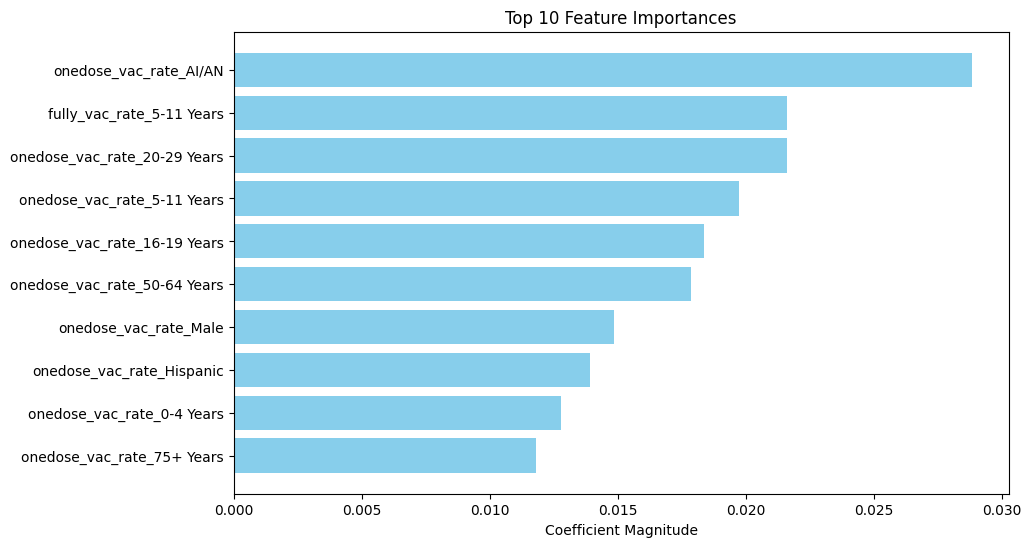

In [176]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X, y)

# Get the absolute values of the coefficients
coefficients = np.abs(model.coef_[0])

# Get the indices of the top 10 features
indices = np.argsort(coefficients)[-10:]

# Get the names of the top 10 features
top_features = [X.columns[i] for i in indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(top_features)), coefficients[indices], color='skyblue', align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Coefficient Magnitude')
plt.show()


In [177]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients_sorted = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients_sorted)


                               Coefficient
onedose_vac_rate_Female       6.693930e-01
fully_vac_rate_White          4.966625e-01
onedose_vac_rate_AI/AN        4.833248e-01
onedose_vac_rate_75+ Years    4.087001e-01
onedose_vac_rate_Hispanic     3.450801e-01
boosted_rate_White            2.197205e-01
fully_vac_rate_5-11 Years     1.525448e-01
fully_vac_rate_Female         1.467145e-01
onedose_vac_rate_50-64 Years  1.349464e-01
boosted_rate_50-64 Years      1.238334e-01
boosted_rate_Asian            1.041026e-01
boosted_rate_12-15 Years      8.953547e-02
boosted_rate_30-49 Years      6.737635e-02
fully_vac_rate_Black          6.137617e-02
boosted_rate_20-29 Years      4.650537e-02
fully_vac_rate_16-19 Years    4.526221e-02
onedose_vac_rate_Black        4.353709e-02
fully_vac_rate_0-4 Years      1.892602e-02
city_Revere                   1.435951e-02
fully_vac_rate_50-64 Years    8.526176e-03
onedose_vac_rate_Male         5.725914e-03
boosted_rate_65-74 Years      3.105407e-03
onedose_vac

In [171]:
# Feature engineering
# Split data into features and target
X = df.drop(['fully_vac_rate', 'year_month', 'city', 'Year','Month','Labor Force',
             'Employed','city_rate','Massachusetts Rate','boosted_rate_Multi',
             'boosted_rate_NH/PI','boosted_rate_Other/Unknown','fully_vac_rate_Multi',
             'fully_vac_rate_NH/PI','fully_vac_rate_Other/Unknown','onedose_vac_rate_Multi',
             'onedose_vac_rate_Other/Unknown','onedose_vac_rate_Total_y','boosted_rate_Total',
             'onedose_vac_rate_Total_x','onedose_vac_rate_Total'], axis=1)  # Features
y = df['fully_vac_rate']  # Target
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (130, 55), y shape: (130,)


In [172]:
# Get dummy variables for city
X = pd.get_dummies(X, drop_first=True)
print(f"X shape: {X.shape}")

# fill out nan with 0
X = X.fillna(0)
y = y.fillna(0)

# Check for infinite or extremely large values in X_train
mask = np.isfinite(X).all(axis=1)
X = X.loc[mask]
y = y.loc[mask]

X shape: (130, 55)


In [173]:
import statsmodels.api as sm

# Add a constant term to the features
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:         fully_vac_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                nan
Time:                        19:21:41   Log-Likelihood:                 1089.9
No. Observations:                  45   AIC:                            -2090.
Df Residuals:                       0   BIC:                            -2009.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1529: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale
